In [2]:
import pretrainedmodels
from fastai2.vision.all import *
import fastai2

import pdb
import torchvision
from lovasz_losses import lovasz_hinge
from tqdm.notebook import tqdm
import cv2
from utils import *
from sklearn.model_selection import KFold
from tqdm.notebook import tqdm
from networks import *

print(fastai2.__version__)
print(torch.__version__)

0.0.13
1.4.0


In [3]:
def get_resnext50(**kwargs):
    model_name = 'se_resnext50_32x4d' 
    model = pretrainedmodels.__dict__[model_name](num_classes=1000, pretrained='imagenet')
    return model

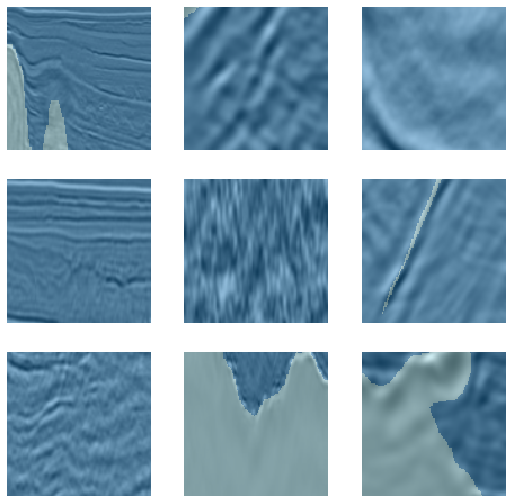

In [4]:
path = Path('../data/tgs/train/')
test_path = Path("../data/tgs/test")
bs = 64
kf = 10
kfold = KFold(n_splits=kf, shuffle=True, random_state=42)
folds = list(kfold.split(X=range_of(get_image_files(path/'images'))))

def KFSplitter(fold_id,folds,**kwargs):
    def _inner(o,**kwargs):
        return folds[fold_id]

def get_data(fold_id,folds,size,bs):
    tfms = [IntToFloatTensor(div_mask=255),Flip(),Brightness(0.1,p=0.25),Zoom(max_zoom=1.1,p=0.25),Normalize.from_stats(*imagenet_stats)]
    db = DataBlock(blocks=(ImageBlock(),MaskBlock()),
                   batch_tfms=tfms,
                   splitter=KFSplitter(fold_id=fold_id,folds=folds),
                   item_tfms=[Resize(size)],
                   get_items=get_image_files,get_y=lambda o:str(o).replace('images','masks'))

    dls = db.dataloaders(path/'images',bs = bs)
    return dls
    

dls = get_data(fold_id=0,folds=folds,size=128,bs=32)
dls.show_batch()

In [5]:
def symmetric_lovasz(outputs, targets):
    return (lovasz_hinge(outputs, targets) + lovasz_hinge(-outputs, 1 - targets)) / 2

def save_pickle(fname,obj):
        pickle.dump(obj,open(f'{fname}.pkl',mode='wb'))
        
def load_pickle(fname):
        return pickle.load(open(f'{fname}.pkl',mode='rb'))

#save_pickle('folds',folds)

folds = load_pickle('folds')
dls = get_data(fold_id=0,folds=folds,size=128,bs=32)

In [6]:
class TGSResNext50(Module):
    def __init__(self):
        self.resnext = create_body(get_resnext50)
        self.encode1 = self.resnext[0][:-1]
        self.encode2 = self.resnext[1]
        self.encode3 = self.resnext[2]
        self.encode4 = self.resnext[3]    
        self.encode5 = self.resnext[4]      
    
    def forward(self,x):
        encode1 = self.encode1(x)
        encode1 = F.max_pool2d(encode1, kernel_size=2, stride=2)        
        encode2 = self.encode2(encode1)
        encode3 = self.encode3(encode2)
        encode4 = self.encode4(encode3)
        encode5 = self.encode5(encode4)
        return encode1,encode2, encode3, encode4, encode5
        
        

In [6]:
x,y = dls.one_batch()

In [7]:
m = TGSResNext50().cuda()

In [8]:
p = m(x)

In [9]:
' '.join(str(o.shape[1]) for o in p)

'64 256 512 1024 2048'

In [7]:
class Decoder(Module):
    def __init__(self,in_channels,chanels,out_channels):
        self.conv1 = ConvLayer(in_channels,chanels)
        self.conv2 = ConvLayer(chanels,out_channels)
        
    def forward(self,x):
        x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=True)
        x = self.conv1(x)
        x = self.conv2(x)
        return x
        

class UnetResNext50(Module):
    def __init__(self):
        fs = 32
        self.resnext = TGSResNext50()
        self.center = nn.Sequential(ConvLayer(2048,2048),ConvLayer(2048,1024))
        self.decoder5 = Decoder(2048+1024,512,fs) 
        self.decoder4 = Decoder(1024+fs,256,fs) 
        self.decoder3 = Decoder(512+fs,128,fs)
        self.decoder2 = Decoder(256+fs,64,fs)
        self.decoder1 = Decoder(fs,fs,fs)
        self.logit = nn.Sequential(ConvLayer(fs*5,64),ConvLayer(64,32),nn.Conv2d(32,1,kernel_size=1))
        
    def forward(self, x):
        e1,e2,e3,e4,e5 = self.resnext(x) #'64 256 512 1024 2048'
        f = self.center(e5)
        d5 = self.decoder5(torch.cat([f, e5], 1))
        d4 = self.decoder4(torch.cat([d5, e4], 1))
        d3 = self.decoder3(torch.cat([d4, e3], 1))
        d2 = self.decoder2(torch.cat([d3, e2], 1))
        d1 = self.decoder1(d2)

        f = torch.cat((
                 d1,
                 F.interpolate(d2, scale_factor=2, mode='bilinear',align_corners=False),
                 F.interpolate(d3, scale_factor=4, mode='bilinear', align_corners=False),
                 F.interpolate(d4, scale_factor=8, mode='bilinear', align_corners=False),
                 F.interpolate(d5, scale_factor=16, mode='bilinear', align_corners=False),

        ), 1)

        logit = self.logit(f)
        return logit

In [ ]:
metrics_all = []
for fold_id in range(kf):
    dls = get_data(fold_id=fold_id,folds=folds,size=128,bs=32)
    learn = Learner(dls,UnetResNext50(),loss_func=symmetric_lovasz,
                    lr=1e-3,
                    wd=1e-7,
                    metrics=[meanapv1],
                    cbs=[SaveModelCallback(monitor='meanapv1',comp=np.greater,fname="best_next-model")])
    learn.fit_one_cycle(60,slice(1e-3))
    metrics_all.append([o[2] for o in learn.recorder.values])
    save_pickle('metrics_all',metrics_all)
    learn.save(f'resnext-{fold_id}')

In [8]:
metrics_all_224 = []
for fold_id in range(kf):
    dls = get_data(fold_id=fold_id,folds=folds,size=224,bs=16)
    learn = Learner(dls,UnetResNext50(),loss_func=symmetric_lovasz,
                    lr=1e-3,
                    wd=1e-7,
                    metrics=[meanapv1],
                    cbs=[SaveModelCallback(monitor='meanapv1',comp=np.greater,fname="best_next-model")])
    learn.load(f'resnext-{fold_id}')
    learn.fit_one_cycle(20,slice(1e-3))
    metrics_all_224.append([o[2] for o in learn.recorder.values])
    save_pickle('metrics_all_224',metrics_all_224)
    learn.save(f'resnext-224-{fold_id}')

epoch,train_loss,valid_loss,meanapv1,time
0,0.709018,0.604227,0.804250,01:58
1,0.520030,0.505132,0.832250,01:52
2,0.514009,0.534013,0.822750,01:52
3,0.534807,0.616309,0.804625,01:52
4,0.618058,0.635018,0.795000,01:52
5,0.530814,0.542219,0.816500,01:52
6,0.609951,0.680035,0.779375,01:52
7,0.523165,0.572977,0.820375,01:52
8,0.460893,0.529514,0.816625,01:52
9,0.406265,0.518103,0.827000,01:52


epoch,train_loss,valid_loss,meanapv1,time
0,0.746479,0.541697,0.816625,01:51
1,0.524539,0.473127,0.838625,01:53
2,0.504240,0.471072,0.834750,01:52
3,0.544954,0.593316,0.809875,01:52
4,0.590210,0.613011,0.795125,01:52
5,0.548693,0.563840,0.817375,01:52
6,0.517272,0.560132,0.819375,01:52
7,0.511192,0.538997,0.806500,01:53
8,0.497614,0.500555,0.833875,01:52
9,0.444316,0.528698,0.826250,01:52


epoch,train_loss,valid_loss,meanapv1,time
0,0.676984,0.523143,0.830500,01:52
1,0.519624,0.458727,0.846125,01:52
2,0.539607,0.485764,0.843750,01:52
3,0.571902,0.493513,0.832125,01:52
4,0.626201,0.507900,0.840000,01:52
5,0.584838,0.589236,0.808875,01:52
6,0.589611,0.599408,0.805375,01:52
7,0.515805,0.685086,0.798000,01:52
8,0.495841,0.547434,0.829875,01:52
9,0.418433,0.515543,0.843125,01:52


epoch,train_loss,valid_loss,meanapv1,time
0,0.736472,0.516777,0.834750,01:52
1,0.572170,0.480721,0.845500,01:52
2,0.536300,0.491331,0.844875,01:52
3,0.590124,0.471230,0.844250,01:52
4,0.571543,0.527996,0.834000,01:53
5,0.606558,0.495474,0.843500,01:52
6,0.528517,0.565798,0.821375,01:52
7,0.582669,0.639505,0.802625,01:53
8,0.483299,0.479312,0.852875,01:52
9,0.498770,0.519090,0.835875,01:52


epoch,train_loss,valid_loss,meanapv1,time
0,0.716470,0.536970,0.821625,01:52
1,0.526569,0.508869,0.827875,01:53
2,0.542058,0.519157,0.821250,01:52
3,0.597385,0.586185,0.807000,01:52
4,0.605720,0.556518,0.808000,01:52
5,0.605395,0.590061,0.773875,01:52
6,0.562050,0.574525,0.807625,01:52
7,0.559721,0.545098,0.811125,01:52
8,0.496704,0.553770,0.820000,01:52
9,0.422952,0.498742,0.818875,01:52


epoch,train_loss,valid_loss,meanapv1,time
0,0.696495,0.515281,0.822750,01:51
1,0.512921,0.452015,0.842375,01:52
2,0.545301,0.485118,0.831625,01:52
3,0.607043,0.531330,0.816875,01:52
4,0.616636,0.536954,0.825375,01:52
5,0.671453,0.585138,0.787500,01:52
6,0.590080,0.548154,0.817625,01:52
7,0.541888,0.510933,0.831500,01:52
8,0.452342,0.516632,0.828000,01:52
9,0.500743,0.498929,0.832750,01:52


epoch,train_loss,valid_loss,meanapv1,time
0,0.694901,0.509739,0.820500,01:52
1,0.527077,0.459680,0.837000,01:52
2,0.512991,0.512099,0.824500,01:52
3,0.591750,0.598757,0.791000,01:52
4,0.603032,0.758172,0.750250,01:52
5,0.524550,0.603464,0.793750,01:52
6,0.544413,0.491819,0.833875,01:52
7,0.522628,0.539010,0.827375,01:52
8,0.468509,0.509271,0.827250,01:53
9,0.429070,0.537498,0.835625,01:52


epoch,train_loss,valid_loss,meanapv1,time
0,0.700639,0.512590,0.837000,01:52
1,0.572353,0.461826,0.845250,01:52
2,0.542263,0.530137,0.834500,01:52
3,0.573446,0.546064,0.826875,01:52
4,0.556040,0.525669,0.829500,01:52
5,0.563725,0.540527,0.829625,01:52
6,0.593308,0.538088,0.829250,01:52
7,0.603701,0.604388,0.810375,01:52
8,0.491775,0.468576,0.849875,01:52
9,0.433126,0.598740,0.830750,01:52


epoch,train_loss,valid_loss,meanapv1,time
0,0.700350,0.545102,0.811125,01:52
1,0.566002,0.488371,0.830000,01:52
2,0.543992,0.593132,0.798250,01:53
3,0.565005,0.537771,0.818000,01:52
4,0.554914,0.607639,0.798500,01:52
5,0.589900,0.612226,0.795250,01:52
6,0.518403,0.565326,0.797000,01:52
7,0.490965,0.580655,0.817125,01:52
8,0.507322,0.566967,0.810750,01:52
9,0.482957,0.556722,0.818000,01:52


epoch,train_loss,valid_loss,meanapv1,time
0,0.640651,0.605971,0.810375,01:52
1,0.500151,0.544475,0.826625,01:52
2,0.526734,0.557777,0.813000,01:52
3,0.553524,0.556741,0.814250,01:52
4,0.560919,0.578419,0.815125,01:52
5,0.539281,0.659996,0.785375,01:52
6,0.541748,0.622710,0.802625,01:52
7,0.499330,0.561483,0.813625,01:53
8,0.489636,0.563892,0.815125,01:52
9,0.411580,0.589138,0.819000,01:52


In [9]:
def get_k_fold_preds(kf,sz=224):
    preds = np.zeros(shape = (18000,sz,sz))
    for fold_id in tqdm(range(kf)):
        learn.load(f'resnext-224-{fold_id}')
        test_preds = array(learn.get_preds(dl=test_dl)[0].squeeze())
        with test_dl_f.dataset.set_split_idx(0):
            test_preds_f = array(learn.get_preds(dl=test_dl_f)[0].squeeze())
        for i,im in enumerate(test_preds):preds[i]+= im
        for i,im in enumerate(test_preds_f):preds[i]+= np.fliplr(im)    
    return preds/kf*2        

In [10]:
dls = get_data(fold_id=0,folds=folds,size=224,bs=16)
test_files = get_image_files(test_path)
test_dl = dls.test_dl(test_files)
test_dl_f = test_dl.new( after_batch=[*test_dl.after_batch,Flip(p=1.0)])
learn = Learner(dls,UnetResNext50(),loss_func=symmetric_lovasz,
                    lr=1e-3,
                    wd=1e-7,
                    metrics=[meanapv1])

In [11]:
preds = get_k_fold_preds(kf,224)

In [12]:
preds_s=array(torch.sigmoid(tensor(preds)))

In [13]:
p = [cv2.resize(o,dsize=(101,101)) for o in preds_s]
p = [(o>0.5).astype(np.uint8) for o in p]

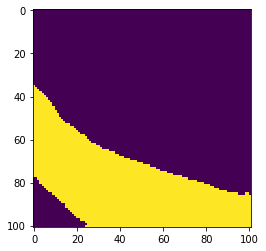

In [14]:
plt.imshow((p[14]).astype(np.uint8))

In [15]:
pred_dict = {o.name.split('.')[0]:RLenc(p[i]) for i,o in enumerate(tqdm(test_files))}
sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
sub.to_csv('submission.csv.gz',compression='gzip')